# t-SNE on Tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd
from scipy import spatial
from collections import defaultdict
import os
import cv2
%matplotlib inline

## Parameters

In [2]:
ndata = 300 # 3000
embed_dim = 3
image_shape = [64,64,1]
image_size = np.prod(image_shape)

---
## Datasets

In [12]:
def load_mnist_dataset(ndata):
    ds = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)
    return  (
        ds.train.images[:ndata],
        ds.train.labels[:ndata],
        ds.test.images[:ndata],
        ds.test.labels[:ndata])

def load_stamps_dataset(ndata):
    path = "/netforge/datasets/common/document_parts/10000/stamp"
    classnum = 1
    
    images = np.zeros([2*ndata, image_size])
    labels = np.zeros([2*ndata, classnum])
    files  = os.listdir(path)[:2*ndata]
    assert len(files) >= 2*ndata, "%s %s" % (len(files), 2*ndata)
    
    for i,f in enumerate(files):
        f = os.path.join(path, f)
        img = cv2.imread(f)
        w = image_shape[0]
        h = image_shape[1]
        img = cv2.resize(img, (w,h), interpolation = cv2.INTER_CUBIC).astype('float32')
        img = np.max(img, axis=2, keepdims=False)
        norm = img.max()+.1
        img = img.astype('float32') / norm        
        # print(img.shape)
        # plt.imshow(img, cmap='gray');
        # plt.show()
        img = np.reshape(img, image_size)
        images[i] = img
        labels[i,0] = 1
    idx = list(range(2*ndata))
    np.random.shuffle(idx)
    images = images[idx]
    labels = labels[idx]
    return (
        images[:ndata],
        labels[:ndata],
        images[ndata:2*ndata],
        labels[ndata:2*ndata])


In [13]:
load_dataset = load_stamps_dataset
train_images, train_labels, test_images, test_labels = load_dataset(ndata)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(300, 4096)
(300, 1)
(300, 4096)
(300, 1)


---
## Visual routines

In [14]:
def PlotEmbedding3d(embeds, labels, title=None, figsize=[10,10]):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    colors = [np.argmax(labels[i]) for i in range(len(embeds))]
    ax.scatter(*zip(*embeds), c=colors, s=100)
    if title:
        plt.title(title)

def PlotEmbeddedDataset3d(images, labels, sess, image_pl, emb_op, npoint=500, title=None, figsize=[10,10]):
    embeds = sess.run(embed_op, feed_dict = {image_pl : images})[:npoint]
    PlotEmbedding3d(embeds, labels[:npoint], title, figsize)

---
## t-SNE

see: https://github.com/maestrojeong/t-SNE

In [15]:
def normalize(array):
    '''
    normalize for 1D array
    '''
    return array/np.sum(array)

def get_entropy(array):
    '''
    Calculate entropy for 1D array
    '''
    if np.sum(array) !=1:
        array = normalize(array)
        
    sum_ = 0
    length = len(array)
    for i in range(length):
        if array[i]!=0:
            sum_+=array[i]*np.log2(array[i])
    return -sum_

def get_prob(sigma_1d):
    '''
    prob[i][j] = p_{j|i}
    '''
    prob = np.zeros([ndata, ndata])
    for i in range(ndata):
        for j in range(ndata):
            prob[i][j] = np.exp(-sq_dist[i][j]/2/sigma_1d[i]/sigma_1d[i])
    
    #diagonal should be 0
    for i in range(ndata):
        prob[i][i] = 0 
    
    for i in range(ndata):
        prob[i] = normalize(prob[i])
    
    return prob

def get_prob_1d(row, sigma):
    '''
    prob[i][j] = p_{j|i}
    return prob[i]
    '''
    prob = np.zeros(ndata)
    for j in range(ndata):
        prob[j] = np.exp(-sq_dist[row][j]/2/sigma/sigma)
    
    #diagonal should be 0
    prob[row] = 0 
    
    return normalize(prob)


def get_perp(entropy):
    return np.power(2, entropy)

def get_shape(tensor):
    return tensor.get_shape().as_list()

def t_sne_loss(y):
    '''
    Arg :
        y - 2D tensor [ndata, nmap]
    '''
    ndata, nmap = get_shape(y)
    y_tr = tf.transpose(y)
    y_mapped = []
    for i in range(nmap):
        y_mapped.append(tf.transpose([y_tr[i]])-y_tr[i])
    y_square = 0
    for i in range(nmap):
        y_square+= tf.square(y_mapped[i])
    y_add = y_square+1
    y_div = tf.div(1., y_add)
    y_mask = y_div*(1-tf.eye(ndata))
    y_sum = tf.reduce_sum(y_mask)
    y_normalize = y_mask/y_sum
    cost = -tf.reduce_mean(joint_prob*tf.log(clip(y_normalize)))
    return cost

def clip(x, vmax = 1-1e-10, vmin = 1e-10):
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

### Compute distances

In [16]:
%%time
sq_dist= np.zeros([ndata, ndata])
for i in range(ndata):
    clear_output(True)
    print("Computing distances: %.1f%% ..." % ((i+1)/ndata*100))
    for j in range(ndata):
        sq_dist[i][j] = np.sum(np.square(train_images[i]-train_images[j]))
print('Done.')

Computing distances: 100.0% ...
Done.
CPU times: user 2.86 s, sys: 116 ms, total: 2.98 s
Wall time: 2.89 s


### Compute probabilities

In [17]:
%%time

sigma = np.ones(ndata)

max_try  = 2000
boundary = 1
perp     = 20

# TODO: vectorize it by numpy or tensorflow

for i in range(ndata):
    smax = np.max(sq_dist)
    smin = np.min(sq_dist)
    cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
    trial = 0
    perp_diff = np.abs(perp - cur_perp)
    clear_output(True)
    print("Computing sigma: %.1f%% ..." % ((i+1)/ndata*100))
    while perp_diff > boundary and trial < max_try:
        trial+=1
        if perp>cur_perp:
            smin = sigma[i]
            sigma[i] = (sigma[i]+smax)/2
        else: 
            smax = sigma[i]
            sigma[i] = (sigma[i]+smin)/2
        cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
        perp_diff = np.abs(perp - cur_perp)

prob = get_prob(sigma)
joint_prob = np.zeros((ndata, ndata))
for i in range(ndata):
    clear_output(True)
    print("Computing joint probs: %.1f%% ..." % ((i+1)/ndata*100))
    for j in range(ndata):
        joint_prob[i][j]=(prob[i][j]+prob[j][i])/2/ndata
        
print('Done.')

Computing joint probs: 100.0% ...
Done.
CPU times: user 22.2 s, sys: 288 ms, total: 22.5 s
Wall time: 22.1 s


---
## TF Neural Networks

In [18]:
def Perceptron(inputs, out_dim):
    l = inputs
    l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=1000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

In [19]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
     

def ConvNet(inputs, inp_shape, out_dim):
    l = tf.reshape(inputs, [-1,] + inp_shape)
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

### Graph

In [20]:
learning_rate = 3e-4

with tf.device('/gpu:0'):
    image_pl = tf.placeholder(dtype = tf.float32, shape = [ndata, image_size], name = 'image_pl')
    embed_op = ConvNet(inputs=image_pl, inp_shape=image_shape, out_dim=embed_dim)
    cost = t_sne_loss(embed_op)*10000
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

def plot_embedding(images, labels, npoint, title=None):
    PlotEmbeddedDataset3d(images, labels, sess, image_pl, embed_op, npoint, title)

### Train

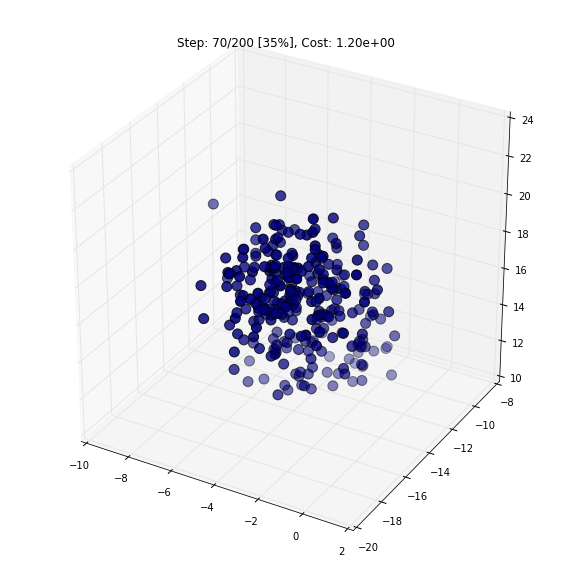

In [ ]:
%%time
train_steps = 200
log_every = 10

cost_tract = []
sess= tf.Session()
sess.run(tf.global_variables_initializer())

try:
    for step in range(train_steps):
        b_images = train_images
        b_labels = train_labels
        
        _, c = sess.run([train_op, cost], feed_dict={image_pl : b_images})
        cost_tract.append(c)
        
        if step%log_every == log_every - 1:
            clear_output(True)
            progress = "Step: %d/%d [%.0f%%], Cost: %.2e" % (step+1, train_steps, 100*(step+1)/train_steps, c)
            # print(progress)
            plot_embedding(b_images, b_labels, 500, progress)
            plt.show()            
except KeyboardInterrupt:
    pass

clear_output(True)
plot_embedding(b_images, b_labels, 500)
plt.show()
plt.plot(cost_tract)
plt.show()
print(progress)

### Validate

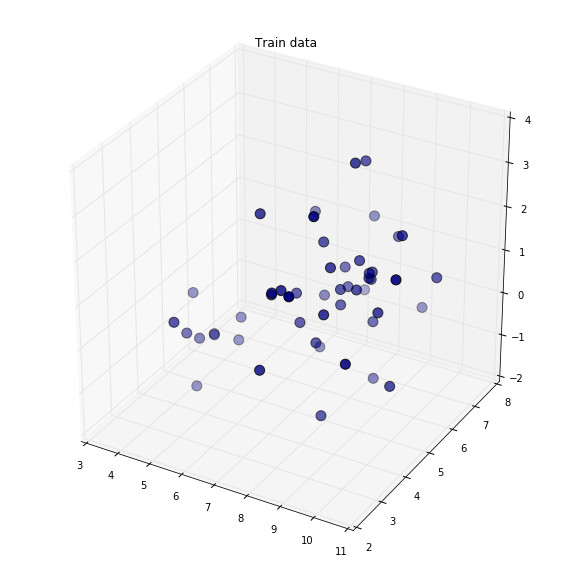

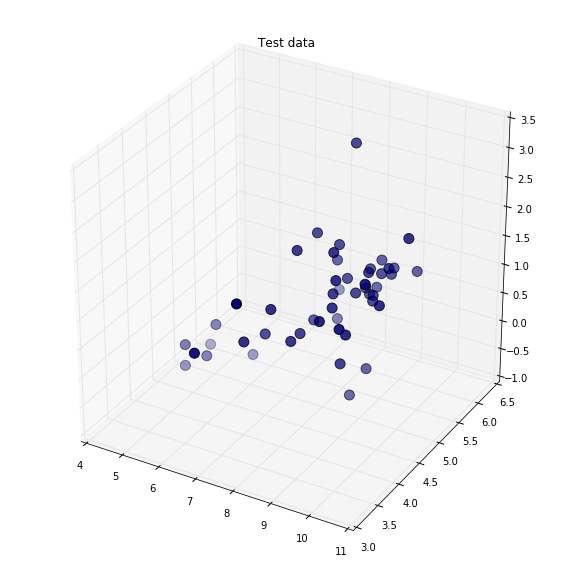

In [56]:
plot_embedding(train_images, train_labels, 2000, "Train data")
plt.show()
plot_embedding(test_images, test_labels, 2000, "Test data")
plt.show()

### Find nearest

Data size: 50 x 3
Targets: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Results: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Quality = 100%


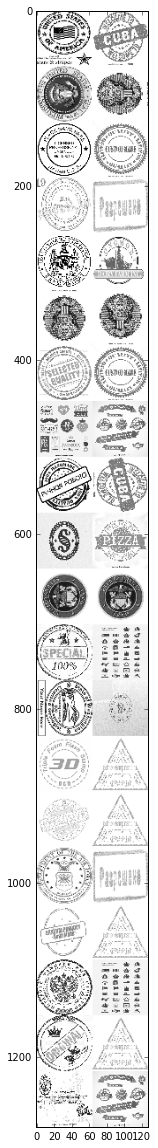

CPU times: user 688 ms, sys: 248 ms, total: 936 ms
Wall time: 666 ms


In [57]:
%%time

def database():
    embeds = sess.run(embed_op, feed_dict = {image_pl : train_images})
    return train_images, embeds, train_labels

def targets(num):
    idx = list(range(ndata))
    np.random.shuffle(idx)
    images = test_images[idx]
    labels = test_labels[idx]

    embeds = sess.run(embed_op, feed_dict = {image_pl : images})
    return images[:num], embeds[:num], labels[:num]

def test_show_targets_embeds(num):
    _, embeds, labels = targets(num)
    PlotEmbedding3d(embeds, labels, "Samples")
    plt.show()

def test_show_targets_images(num):
    images, _, _ = targets(num)
    images = images.reshape([num*image_shape[0],image_shape[1]])
    plt.imshow(images, cmap='gray');
    plt.show()

def label_argmax(labels):
    return np.argmax(labels, axis=1)

def find_nearest(targets, candidates):
    tree = spatial.KDTree(candidates)
    results = tree.query(targets)
    return results[1], results[0] 

def test_find_nearest_images(num):
    trg_img, trg_emb, trg_lbl = targets(num)
    dat_img, dat_emb, dat_lbl = database()

    nearests, distances = find_nearest(trg_emb, dat_emb)
    trg_lbl = label_argmax(trg_lbl)
    res_lbl = label_argmax(dat_lbl[nearests])
    res_img = dat_img[nearests]
    perf = np.sum(trg_lbl==res_lbl) / num

    print("Data size:", ndata, "x", embed_dim)
    print("Targets:", trg_lbl)
    print("Results:", res_lbl)
    print("Quality = %.0f%%" % (perf*100))
    
    img_1 = trg_img.reshape([num*image_shape[0],image_shape[1]])
    img_2 = res_img.reshape([num*image_shape[0],image_shape[1]])
    sheet = np.concatenate([img_1, img_2], axis=1)
    plt.figure(figsize = (60,20))
    plt.imshow(sheet, cmap='gray');
    plt.show()

# test_show_targets_embeds(10)
# test_show_targets_images(10)
test_find_nearest_images(20)